<a href="https://colab.research.google.com/github/mortgad/DLVR/blob/main/Test_2_agegroups.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get Data


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# save_model_path = '/content/drive/MyDrive/DL for VR/Project/Models' # Thomas
#save_model_path = '/content/drive/MyDrive/Deep_Learning_Visual_Recognition/Project/' # Morten
save_model_path = '/content/drive/MyDrive/Visual reg/Project/' # Mads

In [50]:
!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDriveFile
import os
import numpy as np
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pathlib import Path
from tqdm.notebook import tqdm
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from keras.applications import mobilenet_v3
import keras
from keras import layers, models

def create_lists(df):
  import numpy as np
  import pandas as pd
  from PIL import Image
  # Initialize lists to store images and labels
  images = []
  ages = []
  races = []
  genders = []

  # Iterate over each row in the DataFrame
  for _, row in df.iterrows():  # Iterate over each row in the sampled dataframe
    img_path = row['file']           # Extract the file path
    age_code = row['age_code']       # Extract the age code
    race_code = row['race_code']     # Extract the race code
    gender_code = row['gender_code'] # Extract the gender code

    try:
        # Open the image
        img = Image.open(img_path)

        # Convert the image to RGB (if it's grayscale or RGBA)
        img = img.convert("RGB")

        # Resize the image to the target size (224, 224)
        img = img.resize((224, 224))

        # Convert the resized image to a numpy array
        img_array = np.array(img)

        # Ensure the image has the correct shape (224, 224, 3)
        if img_array.shape == (224, 224, 3):
            images.append(img_array)  # Append the image to the list
            ages.append(age_code)  # Append the age code to the 'ages' list
            races.append(race_code)
            genders.append(gender_code)

        else:
            print(f"Skipping image with incorrect shape: {img_path}")
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

  # Convert lists to numpy arrays
  images = np.array(images)
  ages = np.array(ages)
  races = np.array(races)
  genders = np.array(genders)

  return images, ages, races, genders

def split_data(images, ages, races, genders):
  from sklearn.model_selection import train_test_split
  # Reduce sample size
  images_sample, hep_x, ages_sample, hep_y, races_sample, hep_z, genders_sample, hep_w = train_test_split(
      images, ages, races, genders, test_size=0.50, random_state=42, stratify=ages)

  # Split into train (75%) and temp (25%)
  X_train, X_temp, y_train_age, y_temp_age, y_train_races, y_temp_races, y_train_gender, y_temp_gender = train_test_split(
      images_sample, ages_sample, races_sample, genders_sample, test_size=0.25, random_state=42, stratify=ages_sample)

  # Split temp into validation (80% of temp) and test (20% of test)
  X_val, X_test, y_val_age, y_test_age, y_val_races, y_test_races, y_val_gender, y_test_gender = train_test_split(
      X_temp, y_temp_age, y_temp_races, y_temp_gender, test_size=0.20, random_state=42, stratify=y_temp_age)

  # Print output
  print(f"Training set: {X_train.shape}, Training labels: {y_train_age.shape}")
  print(f"Age validation set: {X_val.shape}, Age validation labels: {y_val_age.shape}")
  print(f"Age test set: {X_test.shape}, Age test labels: {y_test_age.shape}")
  print(f"Race validation labels: {y_val_races.shape}")
  print(f"Race test labels: {y_test_races.shape}")
  print(f"Gender validation labels: {y_val_gender.shape}")
  print(f"Gender test labels: {y_test_gender.shape}")

  return X_train, X_val, X_test, y_train_age, y_val_age, y_test_age, y_train_races, y_val_races, y_test_races, y_train_gender, y_val_gender, y_test_gender

# Setting evaluation metrics

In [5]:
def evaluate_and_plot(history, accuracy_key = 'accuracy', val_accuracy_key = 'val_accuracy', loss_key = 'loss', val_loss_key = 'val_loss'):
  import matplotlib.pyplot as plt
  # Get the accuracy and loss data from the history object
  accuracy = history.history[accuracy_key]
  val_accuracy = history.history[val_accuracy_key]
  loss = history.history[loss_key]
  val_loss = history.history[val_loss_key]
  epochs = range(1, len(accuracy) + 1)

  # Find the best accuracy and loss values
  best_acc = max(accuracy)
  best_val_acc = max(val_accuracy)
  best_loss = min(loss)
  best_val_loss = min(val_loss)

  # Print the best values
  print(f"Best Training Accuracy: {best_acc:.4f}")
  print(f"Best Validation Accuracy: {best_val_acc:.4f}")
  print(f"Best Training Loss: {best_loss:.4f}")
  print(f"Best Validation Loss: {best_val_loss:.4f}")

  # Plotting accuracy
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, accuracy, label='Training Accuracy')
  plt.plot(epochs, val_accuracy, label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  # Plotting loss
  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # Show the plots
  plt.tight_layout()
  plt.show()

def plot_confusion_matrix(X_test, y_test, model):
  from sklearn.metrics import confusion_matrix
  import numpy as np
  import matplotlib.pyplot as plt
  import seaborn as sns
  y_pred = model.predict(X_test)  # x_test is your test data
  y_pred = np.argmax(y_pred, axis=1)  # Convert one-hot to sparse integer predictions
  cm = confusion_matrix(y_test, y_pred) # Calculate confusion matrix
  plt.figure(figsize=(10, 7))
  sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=age_group_mapping.values(), yticklabels=age_group_mapping.values())
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

# 1. Loading and preprocessing data FairFace

## Loading

### Loading images

In [6]:
# Step 1: Install PyDrive
!pip install PyDrive

# Step 2: Import the required libraries
import os
import zipfile
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Step 3: Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Step 4: Specify the file ID from the link
file_id = '1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86'

# Step 5: Download the .zip file
downloaded = drive.CreateFile({'id': file_id})
zip_filename = 'downloaded_file.zip'  # Name of the downloaded zip file
downloaded.GetContentFile(zip_filename)

print(f"{zip_filename} downloaded successfully!")

# Step 6: Create the extracted directory if it doesn't exist
extract_dir = '/content/extracted'
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Step 7: Extract the .zip file into the /content/extracted directory
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"File extracted to {extract_dir}")

downloaded_file.zip downloaded successfully!
File extracted to /content/extracted


### Loading labels

In [7]:
# Step 1: Import the necessary libraries if not already imported
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd

# Step 2: Authenticate and create the PyDrive client (if not already done)
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Step 3: Function to download CSV file from Google Drive
def download_csv(file_id, destination):
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.GetContentFile(destination)
    print(f"Downloaded file saved as {destination}")

# Step 4: File IDs and destinations for Train and Validation labels
train_file_id = '1i1L3Yqwaio7YSOCj7ftgk8ZZchPG7dmH'  # Train labels file ID
val_file_id = '1wOdja-ezstMEp81tX1a-EYkFebev4h7D'    # Validation labels file ID

train_labels_path = '/content/train_labels.csv'
val_labels_path = '/content/val_labels.csv'

# Step 5: Download Train and Validation label CSV files
download_csv(train_file_id, train_labels_path)
download_csv(val_file_id, val_labels_path)

df_fairface_train = pd.read_csv(train_labels_path)
df_fairface_val = pd.read_csv(val_labels_path)

Downloaded file saved as /content/train_labels.csv
Downloaded file saved as /content/val_labels.csv


## Data preprocessing
- Currently uses train and validations set defined from the original paper -> no need to use data_split later

In [8]:
from pathlib import Path
from tqdm.notebook import tqdm  # For the progress bar (if not already installed, run: !pip install tqdm)

tqdm.pandas()

train_df = df_fairface_train.copy()
val_df = df_fairface_val.copy()

# Not sure what service_test is
train_df.drop(columns=['service_test'],inplace=True)
val_df.drop(columns=['service_test'],inplace=True)

# Define the base image directory
base_img = Path('/content/extracted')

# Update labels in both train_df and val_df
train_df['age'] = train_df['age'].replace('more than 70', '70+')
val_df['age'] = val_df['age'].replace('more than 70', '70+')

# Update the 'file' column for train and val dataframes
train_df['file'] = train_df['file'].progress_map(lambda x: base_img / x)
val_df['file'] = val_df['file'].progress_map(lambda x: base_img / x)

  0%|          | 0/86744 [00:00<?, ?it/s]

  0%|          | 0/10954 [00:00<?, ?it/s]

In [9]:
###### Mapping gender
gender_map = {'Male': 0, 'Female': 1}

train_df['gender_code'] = train_df['gender'].progress_map(lambda x:gender_map[x])
val_df['gender_code'] = val_df['gender'].progress_map(lambda x:gender_map[x])

###### Mapping age
age_order = ['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']

# Setting the desired order
train_df['age'] = train_df['age'].astype('category')
train_df['age'] = train_df['age'].cat.set_categories(age_order, ordered=True)

# Encoding the age groups
train_df['age_code'] = train_df['age'].cat.codes

# Creating the age map
age_map = dict(zip(train_df['age'].cat.categories, range(len(train_df['age'].cat.categories))))
val_df['age_code'] = val_df['age'].progress_map(lambda x: age_map[x])

###### Mapping race
train_df['race'] = train_df['race'].astype('category')
train_df['race_code'] = train_df['race'].cat.codes

race_map = dict(zip(train_df['race'].cat.categories,range(len(train_df['race'].cat.categories))))
val_df['race_code'] = val_df['race'].progress_map(lambda x:race_map[x])

  0%|          | 0/86744 [00:00<?, ?it/s]

  0%|          | 0/10954 [00:00<?, ?it/s]

  0%|          | 0/10954 [00:00<?, ?it/s]

  0%|          | 0/10954 [00:00<?, ?it/s]

In [10]:
# New desired mapping: White, Black, Asian, Indian, and Others
# Create a function to map the current race categories to the target categories
def map_race_to_target(race):
    if race in ['East Asian', 'Southeast Asian']:
        return 'Asian'
    elif race in ['Latino_Hispanic', 'Middle Eastern']:
        return 'Others'
    else:
        return race  # Retain 'White', 'Black', and 'Indian' as is

# Define the desired category order
desired_order = ['White', 'Black', 'Asian', 'Indian', 'Others']

# Apply the mapping function to map the races to the target categories
train_df['race'] = train_df['race'].map(map_race_to_target)
val_df['race'] = val_df['race'].map(map_race_to_target)

# Convert to categorical type and set the desired category order
train_df['race'] = train_df['race'].astype('category')
train_df['race'] = train_df['race'].cat.set_categories(desired_order, ordered=True)

val_df['race'] = val_df['race'].astype('category')
val_df['race'] = val_df['race'].cat.set_categories(desired_order, ordered=True)

# Create 'race_code' using the ordered categories
train_df['race_code'] = train_df['race'].cat.codes
val_df['race_code'] = val_df['race'].cat.codes

# Create the new race_map based on the new categories
race_map_fair = dict(zip(range(len(desired_order)), desired_order))

# Display the resulting mappings
print("New Race Mapping:", race_map_fair)

New Race Mapping: {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}


In [11]:
# Assuming train_df and val_df are your dataframes
df_fairface_raw = pd.concat([train_df, val_df], ignore_index=True)
print(len(df_fairface_raw))
df_fairface_raw.head()

97698


,file,age,gender,race,gender_code,age_code,race_code
0,/content/extracted/train/1.jpg,50-59,Male,Asian,0,6,2
1,/content/extracted/train/2.jpg,30-39,Female,Indian,1,4,3
2,/content/extracted/train/3.jpg,3-9,Female,Black,1,1,1
3,/content/extracted/train/4.jpg,20-29,Female,Indian,1,3,3
4,/content/extracted/train/5.jpg,20-29,Female,Indian,1,3,3


In [12]:
from PIL import Image
import numpy as np

# Lists to store the extracted data
images_fairface = []
ages_fairface = df_fairface_raw['age_code'].tolist()  # List of age codes
genders_fairface = df_fairface_raw['gender_code'].tolist()  # List of gender codes
ethnicities_fairface = df_fairface_raw['race_code'].tolist()  # List of race codes

In [13]:
df_fairface_eda = df_fairface_raw[['age','gender','race']]
df_fairface_code = df_fairface_raw[['file','age_code','gender_code','race_code']]

### Data test

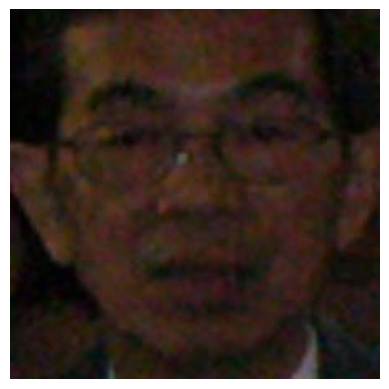

Shape: (224, 224, 3)


In [14]:
import cv2
import matplotlib.pyplot as plt

file_path = '/content/extracted/train/1.jpg'
image = cv2.imread(file_path)

# Convert BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image_rgb)
plt.axis('off')  # Hide axes
plt.show()

# Print the shape of the image
print(f"Shape: {image.shape}")

# 2. Loading and preprocessing data UTKface

## Download data

In [15]:
!pip install PyDrive

In [16]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import tarfile

# Authenticate PyDrive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Folder ID from the shared Google Drive folder
folder_id = '1HROmgviy4jUUUaCdvvrQ8PcqtNg2jn3G'
file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()

# Loop through the files and download each .tar.gz file
for file in file_list:
    if file['title'].endswith('.tar.gz'):
        print(f'Downloading {file["title"]}')
        file.GetContentFile(file['title'])

        # Extract the .tar.gz file
        tar = tarfile.open(file['title'])
        tar.extractall('/content/extracted')  # Extract all files to /content/extracted directory
        tar.close()

        print(f'Extracted {file["title"]}')

Extracted part3.tar.gz
Extracted part2.tar.gz
Extracted part1.tar.gz


## Data Preprocessing

### Data test

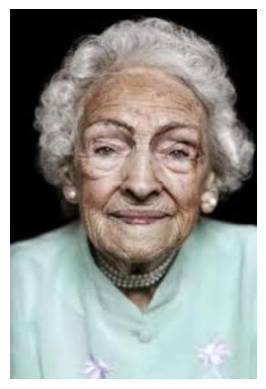

Shape: (551, 368, 3)


In [17]:
import cv2
import matplotlib.pyplot as plt

file_path = '/content/extracted/part3/100_1_0_20170119212053665.jpg'
image = cv2.imread(file_path)

# Convert BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image_rgb)
plt.axis('off')  # Hide axes
plt.show()

# Print the shape of the image
print(f"Shape: {image.shape}")


### Delete non-images

In [18]:
import os

def delete_non_image_files(directories, allowed_extensions=('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
    for directory in directories:
        for filename in os.listdir(directory):
            if not filename.lower().endswith(allowed_extensions):
                file_path = os.path.join(directory, filename)
                os.remove(file_path)
                print(f"Deleted: {file_path}")

# Specify the directories
directories = [
    '/content/extracted/part1',
    '/content/extracted/part2',
    '/content/extracted/part3'
]

# Run the function to delete non-image files
delete_non_image_files(directories)

Deleted: /content/extracted/part3/44_1_4_20170116235150272.pg
Deleted: /content/extracted/part3/55_0_0_20170116232725357jpg
Deleted: /content/extracted/part3/.DS_Store


### Delete invalid mesasges

In [19]:
import os
import re

def delete_invalid_images(directories):
    # Regular expression pattern to match the desired format
    pattern = re.compile(r'^\d+_\d+_\d+_\d+\.\w+$')

    for directory in directories:
        for filename in os.listdir(directory):
            # Check if the filename matches the desired pattern
            if not pattern.match(filename):
                file_path = os.path.join(directory, filename)
                os.remove(file_path)
                print(f"Deleted: {file_path}")

# Specify the directories
directories = [
    '/content/extracted/part1',
    '/content/extracted/part2',
    '/content/extracted/part3'
]

# Run the function to delete invalid images
delete_invalid_images(directories)

Deleted: /content/extracted/part1/61_1_20170109142408075.jpg
Deleted: /content/extracted/part1/61_3_20170109150557335.jpg
Deleted: /content/extracted/part2/53__0_20170116184028385.jpg
Deleted: /content/extracted/part2/39_1_20170116174525125.jpg
Deleted: /content/extracted/part3/24_0_1_20170116220224657 .jpg


### Creating lists for training

In [20]:
import os
import cv2
import numpy as np
import pandas as pd
from pathlib import Path

# Specify the directories
directories = [
    '/content/extracted/part1',
    '/content/extracted/part2',
    '/content/extracted/part3'
]

# Initialize lists to store images and labels
images = []
ages_utkface = []
genders_utkface = []
ethnicities_utkface = []
files_utkface = []  # New list to store file paths

# Process each directory
for directory in directories:
    print(f"Processing from: {directory}")
    files = os.listdir(directory)

    for file in files:
        file_path = os.path.join(directory, file)  # Create the full file path

        if image is not None:  # Check if the image was loaded successfully
            # Parse filename to extract labels
            split_var = file.split('_')
            ages_utkface.append(int(split_var[0]))
            genders_utkface.append(int(split_var[1]))
            ethnicities_utkface.append(int(split_var[2]))
            files_utkface.append(file_path)  # Store the file path in the list
        else:
            print(f"Failed to load image: {file_path}")

# Create a dataframe from the lists
df_utkface = pd.DataFrame({
    'age': ages_utkface,
    'gender': genders_utkface,
    'ethnicity': ethnicities_utkface,
    'file': files_utkface  # Add the file paths as a column
})

Processing from: /content/extracted/part1
Processing from: /content/extracted/part2
Processing from: /content/extracted/part3


In [21]:
# Create a DataFrame from the lists
df_utkface_raw = pd.DataFrame({
    'file': files_utkface,
    'age_raw': ages_utkface,
    'gender_code': genders_utkface,
    'race_code': ethnicities_utkface
})

## Mapping

In [22]:
### Mapping age
# Define the age mapping function
def map_age(age):
    if age <= 2:
        return '0-2'
    elif 3 <= age <= 9:
        return '3-9'
    elif 10 <= age <= 19:
        return '10-19'
    elif 20 <= age <= 29:
        return '20-29'
    elif 30 <= age <= 39:
        return '30-39'
    elif 40 <= age <= 49:
        return '40-49'
    elif 50 <= age <= 59:
        return '50-59'
    elif 60 <= age <= 69:
        return '60-69'
    else:
        return '70+'

# Map the 'age_raw' column to the 'age' column
df_utkface_raw['age'] = df_utkface_raw['age_raw'].apply(map_age)

# Setting the desired order for 'age'
age_order = ['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']
df_utkface_raw['age'] = df_utkface_raw['age'].astype('category')
df_utkface_raw['age'] = df_utkface_raw['age'].cat.set_categories(age_order, ordered=True)

# Encoding the age groups
df_utkface_raw['age_code'] = df_utkface_raw['age'].cat.codes

In [23]:
# Mapping gender
# Define gender mapping
gender_map = {0: 'Male', 1: 'Female'}

# Map 'gender_code' to the 'gender' column
df_utkface_raw['gender'] = df_utkface_raw['gender_code'].map(gender_map)

# Mapping race
# Define race mapping based on the specified order
race_map_utk = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}

# Map 'race_code' to the 'race' column
df_utkface_raw['race'] = df_utkface_raw['race_code'].map(race_map_utk)

In [24]:
df_utkface_code = df_utkface_raw[['file','age_code','gender_code','race_code']]
df_utkface_eda = df_utkface_raw[['age','gender','race']]

# 4. Normalizing age group distribution
Methods
1. Age groups 0-2 and 3-9 are combined into 0-9
3. Add data from UTKface to: 0-9, 10-19, 40-49, 50-59, 60-69, and 70+

## Current distributions

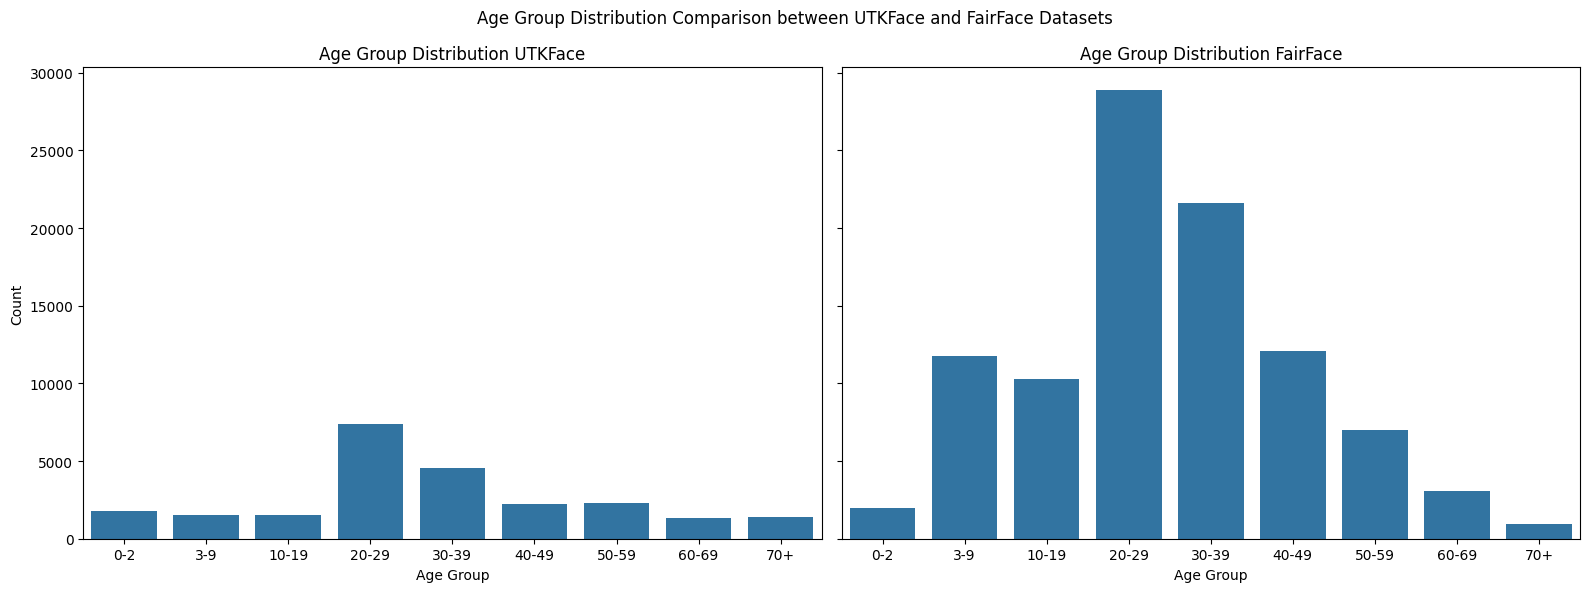

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot the first distribution for the UTKFace dataset
sns.countplot(data=df_utkface_code, x='age_code', ax=axes[0])
axes[0].set_title('Age Group Distribution UTKFace')
axes[0].set_xlabel('Age Group')
axes[0].set_ylabel('Count')
axes[0].set_xticks(range(len(age_map)))
axes[0].set_xticklabels(age_map.keys())

# Plot the second distribution for the FairFace dataset
sns.countplot(data=df_fairface_code, x='age_code', ax=axes[1])
axes[1].set_title('Age Group Distribution FairFace')
axes[1].set_xlabel('Age Group')
axes[1].set_ylabel('Count')
axes[1].set_xticks(range(len(age_map)))
axes[1].set_xticklabels(age_map.keys())

# Adjust the layout and show the plots
plt.suptitle('Age Group Distribution Comparison between UTKFace and FairFace Datasets')
plt.tight_layout()
plt.show()

## Fairface

In [89]:
# Step 1: Define the mapping to merge age groups
def merge_age_groups(age_code):
    if age_code in [0, 1]:
        return 0  # Merge age groups 0 (0-2) and 1 (3-9)
    #elif age_code in [6, 7, 8]:
        #return 7  # Merge age groups 7(60-69), and 8(70+) into group 7(60-69)
    else:
        return age_code  # Keep other age groups unchanged

# Make sure df_fairface is a true copy to avoid modifying a slice
df_fairface = df_fairface_code.copy()

# Apply the merge mapping to the 'age_code' column using .loc to avoid SettingWithCopyWarning
df_fairface.loc[:, 'age_code'] = df_fairface['age_code'].map(merge_age_groups)

# Step 2: Create a sequential mapping for the merged groups
sequential_mapping = {
    0: 0,  # '0-9'
    2: 1,  # '10-19'
    3: 2,  # '20-29'
    4: 3,  # '30-39'
    5: 4,  # '40-49'
    6: 5,  # 50-59
    7: 6,  # 60-69
    8: 7,  # 70+
}

# Apply the sequential mapping using .loc
df_fairface.loc[:, 'age_code'] = df_fairface['age_code'].map(sequential_mapping)

# Step 3: Update the age group labels accordingly
age_group_mapping = {
    0: '0-9',     # Group 0
    1: '10-19',   # Group 1 (previously group 2)
    2: '20-29',   # Group 2
    3: '30-39',   # Group 3
    4: '40-49',   # Group 4
    5: '50-59',   # Group 5 (previously group 6)
    6: '60-69',   # Group 6 (previously group 7)
    7: '70+',   # Group 7 (previously group 8)
}

# Map the new age group labels based on the updated 'age_code' using .loc
df_fairface.loc[:, 'age'] = df_fairface['age_code'].map(age_group_mapping)


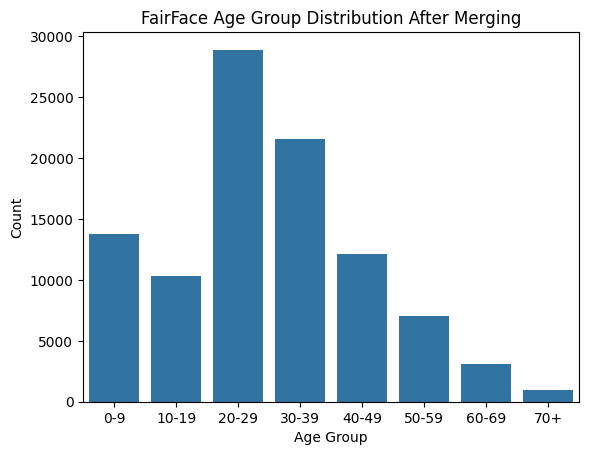

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the correct order of the age groups based on the mapping
age_order = sorted(df_fairface['age_code'].unique())
age_labels = [age_group_mapping[code] for code in age_order]  # Corresponding labels

# Plot the countplot with the specified order and labels
sns.countplot(data=df_fairface, x='age_code', order=age_order)
plt.xticks(ticks=age_order, labels=age_labels)  # Set the x-tick labels directly

# Adding plot labels
plt.title('FairFace Age Group Distribution After Merging')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Show the plot
plt.show()

## UTKFace

In [91]:
# Step 1: Define the mapping to merge age groups
def merge_age_groups(age_code):
    if age_code in [0, 1]:
        return 0  # Merge age groups 0 (0-2) and 1 (3-9)
    #elif age_code in [7, 8]:
        #return 7  # Merge age groups 7(60-69), and 8(70+) into group 7(60-69)
    else:
        return age_code  # Keep other age groups unchanged

# Make sure df_fairface is a true copy to avoid modifying a slice
df_utkface = df_utkface_code.copy()

# Explicitly cast the 'age_code' column to a larger integer type to avoid dtype issues
df_utkface['age_code'] = df_utkface['age_code'].astype('int64')

# Apply the merge mapping to the 'age_code' column using .loc to avoid SettingWithCopyWarning
df_utkface.loc[:, 'age_code'] = df_utkface['age_code'].map(merge_age_groups)

# Step 2: Create a sequential mapping for the merged groups
sequential_mapping = {
    0: 0,  # '0-9'
    2: 1,  # '10-19'
    3: 2,  # '20-29'
    4: 3,  # '30-39'
    5: 4,  # '40-49'
    6: 5,  # 50-59
    7: 6,  # 60-69
    8: 7,  # 70+
}

# Apply the sequential mapping using .loc
df_utkface.loc[:, 'age_code'] = df_utkface['age_code'].map(sequential_mapping)

# Step 3: Update the age group labels accordingly
age_group_mapping = {
    0: '0-9',     # Group 0
    1: '10-19',   # Group 1 (previously group 2)
    2: '20-29',   # Group 2
    3: '30-39',   # Group 3
    4: '40-49',   # Group 4
    5: '50-59',   # Group 5 (previously group 6)
    6: '60-69',   # Group 6 (previously group 7)
    7: '70+',   # Group 7 (previously group 8)
}

# Map the new age group labels based on the updated 'age_code' using .loc
df_utkface.loc[:, 'age'] = df_utkface['age_code'].map(age_group_mapping)

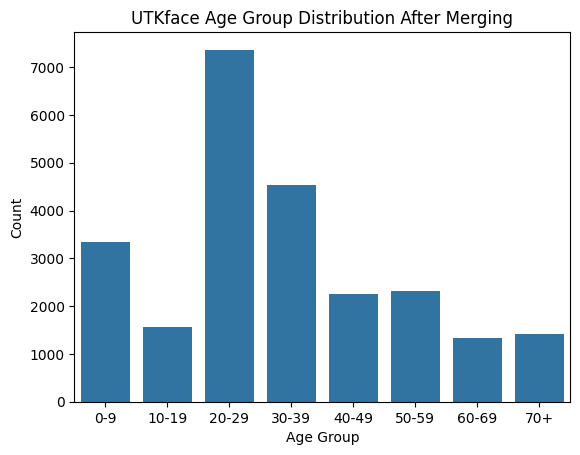

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the correct order of the age groups based on the mapping
age_order = sorted(df_utkface['age_code'].unique())
age_labels = [age_group_mapping[code] for code in age_order]  # Corresponding labels

# Plot the countplot with the specified order and labels
sns.countplot(data=df_utkface, x='age_code', order=age_order)
plt.xticks(ticks=age_order, labels=age_labels)  # Set the x-tick labels directly

# Adding plot labels
plt.title('UTKface Age Group Distribution After Merging')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Show the plot
plt.show()

## Concatenating age groups 0, 1, 4, 5, and 6
- Age groups: 0-9, 10-19, 40-49, 50-59, and 60+

<ipython-input-93-aa1b0141c384>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_utkface['dataset'] = 'UTK'


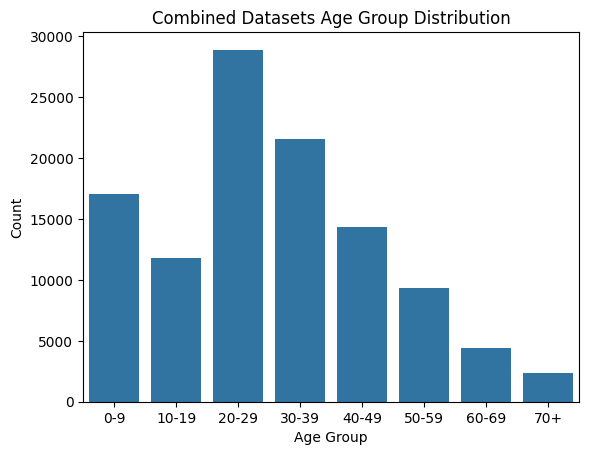

In [93]:
import pandas as pd

# Step 1: Filter `df_utkface` to include only the specified age groups
filtered_utkface = df_utkface[df_utkface['age_code'].isin([0, 1, 4, 5, 6, 7])]

# Add columns indicating if the image is from UTK or FairFace
filtered_utkface['dataset'] = 'UTK'
df_fairface['dataset'] = 'FairFace'

# Step 2: Concatenate the filtered `df_utkface` with `df_fairface`
df = pd.concat([df_fairface, filtered_utkface], ignore_index=True)

# Define the correct order of the age groups based on the mapping
age_order = sorted(df['age_code'].unique())
age_labels = [age_group_mapping[code] for code in age_order]  # Corresponding labels

# Plot the countplot with the specified order and labels
sns.countplot(data=df, x='age_code', order=age_order)
plt.xticks(ticks=age_order, labels=age_labels)  # Set the x-tick labels directly

# Adding plot labels
plt.title('Combined Datasets Age Group Distribution')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Show the plot
plt.show()

In [94]:
df['age_code'] = df['age_code'].apply(lambda x: 0 if 0 <= x <= 2 else 1)

# 5. Downsample and split data into train, val and test

In [95]:
df.shape

(109890, 6)

In [96]:
# Find age group with lowest n
lowest_n = df['age'].value_counts().sort_values(ascending=True).iloc[0]

# Downsample
df_down = df.groupby('age').apply(lambda x: x.sample(lowest_n)).reset_index(drop=True)

# Display
df_down.head()

df_down.groupby('age_code').size()

<ipython-input-96-6af78e0d1284>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_down = df.groupby('age').apply(lambda x: x.sample(lowest_n)).reset_index(drop=True)


,0
age_code,
0,7122
1,11870


### Race codes

#### UTKFace:

0: 'White'

1: 'Black'

2: 'Asian'

3: 'Indian'

4: 'Others'


#### FairFace:

0: 'White'

1: 'Black'

2: 'Asian'

3: 'Indian'

4: 'Others'

In [55]:
from keras.applications.resnet_v2 import preprocess_input  # Update the import for ResNet50V2
from keras.applications import ResNet50V2  # Import the ResNet50V2 model
from keras import layers, models  # Import the required modules

# Step 1: Create lists of images and labels
images, ages, races, genders = create_lists(df_down)
print(f"Loaded {len(images)} images.")

# Step 2: Apply ResNet preprocessing
images_preprocessed = preprocess_input(images)

# Step 3: Get the number of classes for each target variable
num_classes_age = len(set(ages))
num_classes_gender = len(set(genders))
num_classes_ethnicity = len(set(races))
print(f"Number of age classes: {num_classes_age}")
print(f"Number of gender classes: {num_classes_gender}")
print(f"Number of ethnicity classes: {num_classes_ethnicity}")

# Step 4: Split the preprocessed data into training, validation, and test sets
X_train, X_val, X_test, y_train_age, y_val_age, y_test_age, y_train_races, y_val_races, y_test_races, y_train_gender, y_val_gender, y_test_gender = split_data(images_preprocessed, ages, races, genders)

# Print the shapes of the resulting datasets
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")



Loaded 18992 images.
Number of age classes: 2
Number of gender classes: 2
Number of ethnicity classes: 5
Training set: (7122, 224, 224, 3), Training labels: (7122,)
Age validation set: (1899, 224, 224, 3), Age validation labels: (1899,)
Age test set: (475, 224, 224, 3), Age test labels: (475,)
Race validation labels: (1899,)
Race test labels: (475,)
Gender validation labels: (1899,)
Gender test labels: (475,)
Training set shape: (7122, 224, 224, 3)
Validation set shape: (1899, 224, 224, 3)
Test set shape: (475, 224, 224, 3)


# 7. Baseline ResNet50V2
- learning rate at 0.00015 (1,5e-4)

In [56]:
# Now proceed with the ResNet50V2 model using the preprocessed images
conv_base = ResNet50V2(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet",  # Load pre-trained ImageNet weights
    input_shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]),  # Input shape from the preprocessed images
)

conv_base.trainable = False  # Freeze the pre-trained layers

# Create the new model using ResNet50V2 as the base
inputs = keras.Input(shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]))
x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)

# Adjust the number of classes for the output layers based on your task (e.g., age prediction, races, gender)
outputs = layers.Dense(num_classes_age, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

94668760/94668760 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                              

In [57]:
# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=1.5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

# Define the callback for saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
file_path = save_model_path + "/"
model_name = 'resnet50v2_model_baseline.keras'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# Train the model
resnet_history = model.fit(
    X_train,
    y_train_age,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)


Epoch 1/30
223/223 [==============================] - ETA: 0s - loss: 0.4927 - accuracy: 0.7585
Epoch 1: val_accuracy improved from -inf to 0.78726, saving model to /content/drive/MyDrive/Visual reg/Project/resnet50v2_model_baseline.keras
223/223 [==============================] - 120s 517ms/step - loss: 0.4927 - accuracy: 0.7585 - val_loss: 0.4345 - val_accuracy: 0.7873
Epoch 2/30
223/223 [==============================] - ETA: 0s - loss: 0.3103 - accuracy: 0.8631
Epoch 2: val_accuracy improved from 0.78726 to 0.81201, saving model to /content/drive/MyDrive/Visual reg/Project/resnet50v2_model_baseline.keras
223/223 [==============================] - 111s 500ms/step - loss: 0.3103 - accuracy: 0.8631 - val_loss: 0.4271 - val_accuracy: 0.8120
Epoch 3/30
223/223 [==============================] - ETA: 0s - loss: 0.2288 - accuracy: 0.9078
Epoch 3: val_accuracy did not improve from 0.81201
223/223 [==============================] - 107s 481ms/step - loss: 0.2288 - accuracy: 0.9078 - val_los

Best Training Accuracy: 0.9937
Best Validation Accuracy: 0.8152
Best Training Loss: 0.0194
Best Validation Loss: 0.4271


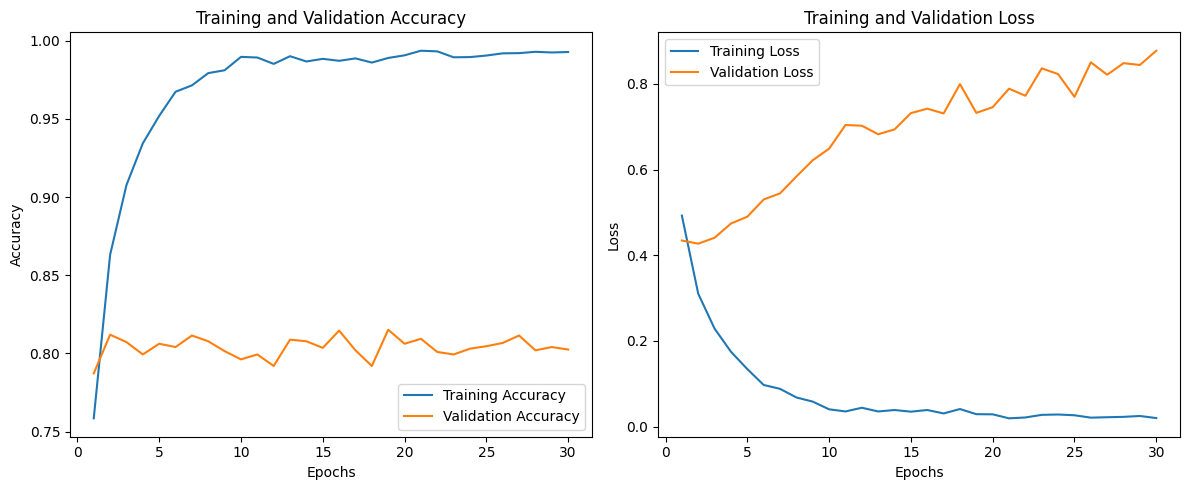

In [58]:
evaluate_and_plot(resnet_history)

# Under 19


# 4. Normalizing age group distribution
Methods
1. Age groups 0-2 and 3-9 are combined into 0-9
3. Add data from UTKface to: 0-9, 10-19, 40-49, 50-59, 60-69, and 70+

## Current distributions

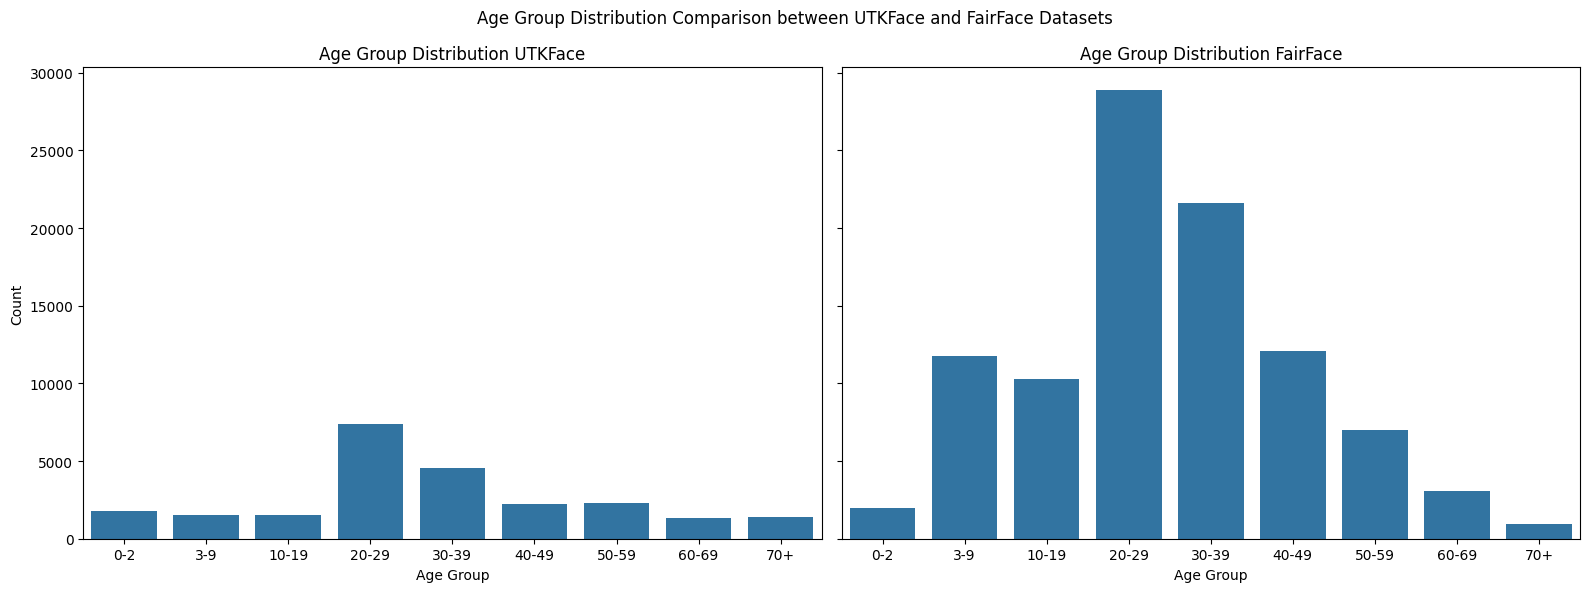

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot the first distribution for the UTKFace dataset
sns.countplot(data=df_utkface_code, x='age_code', ax=axes[0])
axes[0].set_title('Age Group Distribution UTKFace')
axes[0].set_xlabel('Age Group')
axes[0].set_ylabel('Count')
axes[0].set_xticks(range(len(age_map)))
axes[0].set_xticklabels(age_map.keys())

# Plot the second distribution for the FairFace dataset
sns.countplot(data=df_fairface_code, x='age_code', ax=axes[1])
axes[1].set_title('Age Group Distribution FairFace')
axes[1].set_xlabel('Age Group')
axes[1].set_ylabel('Count')
axes[1].set_xticks(range(len(age_map)))
axes[1].set_xticklabels(age_map.keys())

# Adjust the layout and show the plots
plt.suptitle('Age Group Distribution Comparison between UTKFace and FairFace Datasets')
plt.tight_layout()
plt.show()

## Fairface

In [109]:
# Step 1: Define the mapping to merge age groups
def merge_age_groups(age_code):
    if age_code in [0, 1]:
        return 0  # Merge age groups 0 (0-2) and 1 (3-9)
    #elif age_code in [6, 7, 8]:
        #return 7  # Merge age groups 7(60-69), and 8(70+) into group 7(60-69)
    else:
        return age_code  # Keep other age groups unchanged

# Make sure df_fairface is a true copy to avoid modifying a slice
df_fairface = df_fairface_code.copy()

# Apply the merge mapping to the 'age_code' column using .loc to avoid SettingWithCopyWarning
df_fairface.loc[:, 'age_code'] = df_fairface['age_code'].map(merge_age_groups)

# Step 2: Create a sequential mapping for the merged groups
sequential_mapping = {
    0: 0,  # '0-9'
    2: 1,  # '10-19'
    3: 2,  # '20-29'
    4: 3,  # '30-39'
    5: 4,  # '40-49'
    6: 5,  # 50-59
    7: 6,  # 60-69
    8: 7,  # 70+
}

# Apply the sequential mapping using .loc
df_fairface.loc[:, 'age_code'] = df_fairface['age_code'].map(sequential_mapping)

# Step 3: Update the age group labels accordingly
age_group_mapping = {
    0: '0-9',     # Group 0
    1: '10-19',   # Group 1 (previously group 2)
    2: '20-29',   # Group 2
    3: '30-39',   # Group 3
    4: '40-49',   # Group 4
    5: '50-59',   # Group 5 (previously group 6)
    6: '60-69',   # Group 6 (previously group 7)
    7: '70+',   # Group 7 (previously group 8)
}

# Map the new age group labels based on the updated 'age_code' using .loc
df_fairface.loc[:, 'age'] = df_fairface['age_code'].map(age_group_mapping)


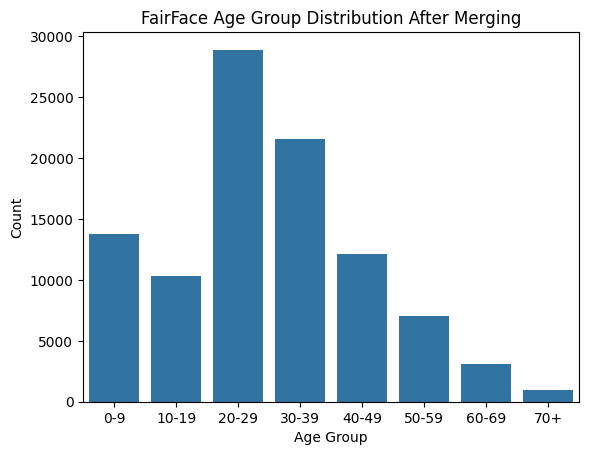

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the correct order of the age groups based on the mapping
age_order = sorted(df_fairface['age_code'].unique())
age_labels = [age_group_mapping[code] for code in age_order]  # Corresponding labels

# Plot the countplot with the specified order and labels
sns.countplot(data=df_fairface, x='age_code', order=age_order)
plt.xticks(ticks=age_order, labels=age_labels)  # Set the x-tick labels directly

# Adding plot labels
plt.title('FairFace Age Group Distribution After Merging')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Show the plot
plt.show()

## UTKFace

In [111]:
# Step 1: Define the mapping to merge age groups
def merge_age_groups(age_code):
    if age_code in [0, 1]:
        return 0  # Merge age groups 0 (0-2) and 1 (3-9)
    #elif age_code in [7, 8]:
        #return 7  # Merge age groups 7(60-69), and 8(70+) into group 7(60-69)
    else:
        return age_code  # Keep other age groups unchanged

# Make sure df_fairface is a true copy to avoid modifying a slice
df_utkface = df_utkface_code.copy()

# Explicitly cast the 'age_code' column to a larger integer type to avoid dtype issues
df_utkface['age_code'] = df_utkface['age_code'].astype('int64')

# Apply the merge mapping to the 'age_code' column using .loc to avoid SettingWithCopyWarning
df_utkface.loc[:, 'age_code'] = df_utkface['age_code'].map(merge_age_groups)

# Step 2: Create a sequential mapping for the merged groups
sequential_mapping = {
    0: 0,  # '0-9'
    2: 1,  # '10-19'
    3: 2,  # '20-29'
    4: 3,  # '30-39'
    5: 4,  # '40-49'
    6: 5,  # 50-59
    7: 6,  # 60-69
    8: 7,  # 70+
}

# Apply the sequential mapping using .loc
df_utkface.loc[:, 'age_code'] = df_utkface['age_code'].map(sequential_mapping)

# Step 3: Update the age group labels accordingly
age_group_mapping = {
    0: '0-9',     # Group 0
    1: '10-19',   # Group 1 (previously group 2)
    2: '20-29',   # Group 2
    3: '30-39',   # Group 3
    4: '40-49',   # Group 4
    5: '50-59',   # Group 5 (previously group 6)
    6: '60-69',   # Group 6 (previously group 7)
    7: '70+',   # Group 7 (previously group 8)
}

# Map the new age group labels based on the updated 'age_code' using .loc
df_utkface.loc[:, 'age'] = df_utkface['age_code'].map(age_group_mapping)

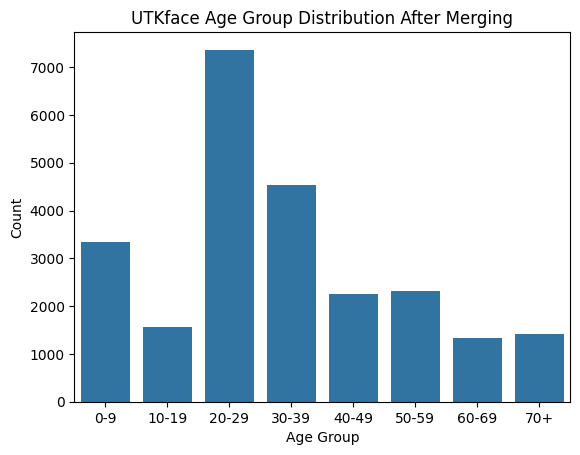

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the correct order of the age groups based on the mapping
age_order = sorted(df_utkface['age_code'].unique())
age_labels = [age_group_mapping[code] for code in age_order]  # Corresponding labels

# Plot the countplot with the specified order and labels
sns.countplot(data=df_utkface, x='age_code', order=age_order)
plt.xticks(ticks=age_order, labels=age_labels)  # Set the x-tick labels directly

# Adding plot labels
plt.title('UTKface Age Group Distribution After Merging')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Show the plot
plt.show()

## Concatenating age groups 0, 1, 4, 5, and 6
- Age groups: 0-9, 10-19, 40-49, 50-59, and 60+

<ipython-input-113-aa1b0141c384>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_utkface['dataset'] = 'UTK'


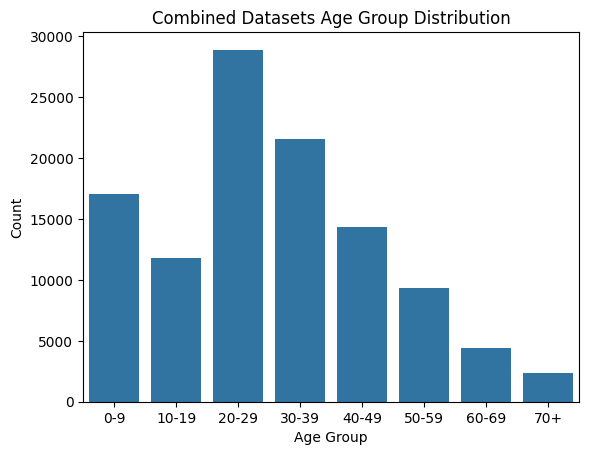

In [113]:
import pandas as pd

# Step 1: Filter `df_utkface` to include only the specified age groups
filtered_utkface = df_utkface[df_utkface['age_code'].isin([0, 1, 4, 5, 6, 7])]

# Add columns indicating if the image is from UTK or FairFace
filtered_utkface['dataset'] = 'UTK'
df_fairface['dataset'] = 'FairFace'

# Step 2: Concatenate the filtered `df_utkface` with `df_fairface`
df = pd.concat([df_fairface, filtered_utkface], ignore_index=True)

# Define the correct order of the age groups based on the mapping
age_order = sorted(df['age_code'].unique())
age_labels = [age_group_mapping[code] for code in age_order]  # Corresponding labels

# Plot the countplot with the specified order and labels
sns.countplot(data=df, x='age_code', order=age_order)
plt.xticks(ticks=age_order, labels=age_labels)  # Set the x-tick labels directly

# Adding plot labels
plt.title('Combined Datasets Age Group Distribution')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Show the plot
plt.show()

In [114]:
df['age_code'] = df['age_code'].apply(lambda x: 0 if 0 <= x <= 1 else 1)

In [115]:
# Find age group with lowest n
lowest_n = df['age'].value_counts().sort_values(ascending=True).iloc[0]

# Downsample
df_down = df.groupby('age').apply(lambda x: x.sample(lowest_n)).reset_index(drop=True)

# Display
df_down.head()

<ipython-input-115-11961f80dd77>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_down = df.groupby('age').apply(lambda x: x.sample(lowest_n)).reset_index(drop=True)


,file,age_code,gender_code,race_code,age,dataset
0,/content/extracted/part1/2_1_4_201612212015365...,0,1,4,0-9,UTK
1,/content/extracted/train/27381.jpg,0,0,4,0-9,FairFace
2,/content/extracted/train/40903.jpg,0,0,2,0-9,FairFace
3,/content/extracted/part1/6_1_2_201612192057489...,0,1,2,0-9,UTK
4,/content/extracted/train/51590.jpg,0,0,4,0-9,FairFace


# Splitting data and model

In [119]:
from keras.applications.resnet_v2 import preprocess_input  # Update the import for ResNet50V2
from keras.applications import ResNet50V2  # Import the ResNet50V2 model
from keras import layers, models  # Import the required modules

# Step 1: Create lists of images and labels
images, ages, races, genders = create_lists(df_down)
print(f"Loaded {len(images)} images.")

# Step 2: Apply ResNet preprocessing
images_preprocessed = preprocess_input(images)

# Step 3: Get the number of classes for each target variable
num_classes_age = len(set(ages))
num_classes_gender = len(set(genders))
num_classes_ethnicity = len(set(races))
print(f"Number of age classes: {num_classes_age}")
print(f"Number of gender classes: {num_classes_gender}")
print(f"Number of ethnicity classes: {num_classes_ethnicity}")

# Step 4: Split the preprocessed data into training, validation, and test sets
X_train, X_val, X_test, y_train_age, y_val_age, y_test_age, y_train_races, y_val_races, y_test_races, y_train_gender, y_val_gender, y_test_gender = split_data(images_preprocessed, ages, races, genders)

# Print the shapes of the resulting datasets
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Loaded 18992 images.
Number of age classes: 2
Number of gender classes: 2
Number of ethnicity classes: 5
Training set: (7122, 224, 224, 3), Training labels: (7122,)
Age validation set: (1899, 224, 224, 3), Age validation labels: (1899,)
Age test set: (475, 224, 224, 3), Age test labels: (475,)
Race validation labels: (1899,)
Race test labels: (475,)
Gender validation labels: (1899,)
Gender test labels: (475,)
Training set shape: (7122, 224, 224, 3)
Validation set shape: (1899, 224, 224, 3)
Test set shape: (475, 224, 224, 3)


In [120]:
# Now proceed with the ResNet50V2 model using the preprocessed images
conv_base = ResNet50V2(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet",  # Load pre-trained ImageNet weights
    input_shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]),  # Input shape from the preprocessed images
)

conv_base.trainable = False  # Freeze the pre-trained layers

# Create the new model using ResNet50V2 as the base
inputs = keras.Input(shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]))
x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)

# Adjust the number of classes for the output layers based on your task (e.g., age prediction, races, gender)
outputs = layers.Dense(num_classes_age, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_4 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_5 (Bat  (None, 512)               2048

In [121]:
# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=1.5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

# Define the callback for saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
file_path = save_model_path + "/"
model_name = '19_resnet50v2_model_baseline.keras'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# Train the model
resnet_history = model.fit(
    X_train,
    y_train_age,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)


Epoch 1/10
223/223 [==============================] - ETA: 0s - loss: 0.4270 - accuracy: 0.8030
Epoch 1: val_accuracy improved from -inf to 0.83465, saving model to /content/drive/MyDrive/Visual reg/Project/19_resnet50v2_model_baseline.keras
223/223 [==============================] - 119s 515ms/step - loss: 0.4270 - accuracy: 0.8030 - val_loss: 0.3768 - val_accuracy: 0.8346
Epoch 2/10
223/223 [==============================] - ETA: 0s - loss: 0.2574 - accuracy: 0.8947
Epoch 2: val_accuracy improved from 0.83465 to 0.83834, saving model to /content/drive/MyDrive/Visual reg/Project/19_resnet50v2_model_baseline.keras
223/223 [==============================] - 113s 509ms/step - loss: 0.2574 - accuracy: 0.8947 - val_loss: 0.3744 - val_accuracy: 0.8383
Epoch 3/10
223/223 [==============================] - ETA: 0s - loss: 0.1887 - accuracy: 0.9260
Epoch 3: val_accuracy improved from 0.83834 to 0.84044, saving model to /content/drive/MyDrive/Visual reg/Project/19_resnet50v2_model_baseline.kera

Best Training Accuracy: 0.9900
Best Validation Accuracy: 0.8452
Best Training Loss: 0.0355
Best Validation Loss: 0.3744


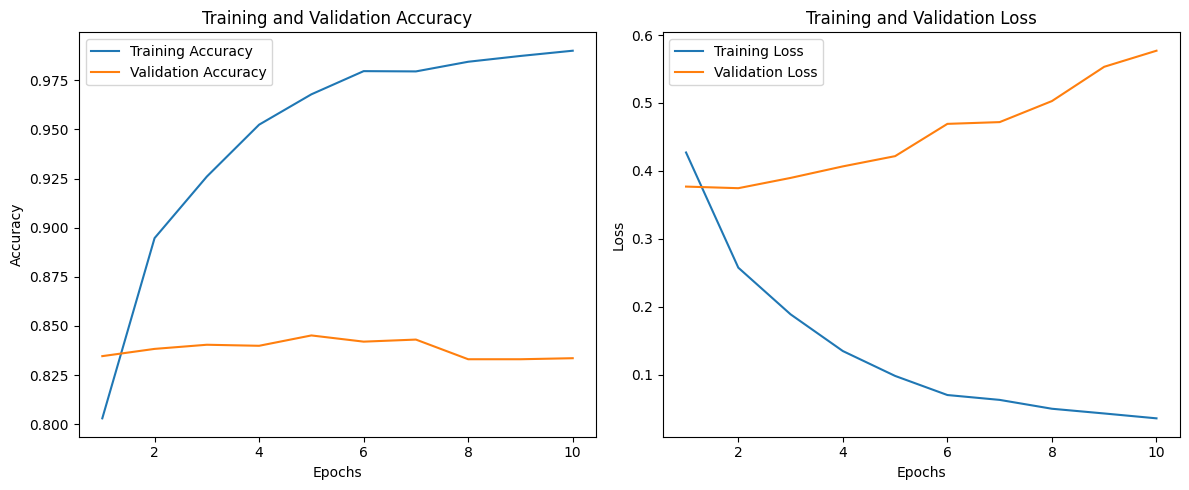

In [122]:
evaluate_and_plot(resnet_history)